In [1]:
import os
import numpy as np
import collections
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, np_utils
from keras.layers import Dense, Input, Embedding,Conv1D,MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D
from keras.models import Model, Sequential
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [2]:
#Import pre-trained word vector and form a dictionary in which words in the embedding set are mapped to their respective embedding vector

embeddings_dict = {}
glove_file = open('glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
    values = line.split()
    word = values[0]
    coefficients = np.asarray(values[1:], dtype='float32')
    embeddings_dict[word] = coefficients
glove_file.close()

print('%s word-embedding_vectors added in dictonary' % len(embeddings_dict))

400000 word-embedding_vectors added in dictonary


In [3]:
#Import dataset.
df = pd.read_csv("globalenglish_essay_scoring.csv", encoding = 'latin1')
df = df[np.isfinite(df['domain1_score'])]
essay_text = df.essay

In [4]:
#Count words in longest essay so as to pad sentence to match length 
counter = collections.Counter()
maxlen = 0
for line in essay_text:
    sent = line.strip()
    words = [x.lower() for x in nltk.word_tokenize(sent)]
    if len(words) > maxlen:
        maxlen = len(words)
    
    for word in words:
        counter[word] += 1
        
print ('%s words found in dataset' % len(counter.keys()))        
print('%s words in longest essay' % maxlen)

45026 words found in dataset
1204 words in longest essay


In [5]:
VOCAB_SIZE = 40000
EMBEDDING_DIM = 100
BATCH_SIZE = 128
NUM_EPOCHS = 10
NUM_FILTERS = 128
NUM_WORDS = 5

In [6]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(essay_text)
sequences = tokenizer.texts_to_sequences(essay_text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=maxlen)
eset = df.essay_set.values.reshape(df.essay_set.shape[0], 1)
X = np.append(X, eset, 1)
maxlen = maxlen + 1

#Convert labels into one hot matrix
score = df.domain1_score
Y = np_utils.to_categorical(score)

print('Shape of input data:', X.shape)
print('Shape of label:', Y.shape)

Found 41432 unique tokens.
Shape of input data: (12977, 1205)
Shape of label: (12977, 61)


In [7]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(10381, 1205) (2596, 1205) (10381, 61) (2596, 61)


In [8]:
# prepare embedding matrix
num_words = len(word_index)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= maxlen:
        continue
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)


inp = Input(shape=(maxlen, ))
x = embedding_layer(inp)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(61, activation='relu')(x)
y = Dense(61, activation='softmax')(x)

In [9]:
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation="relu"))
model.add(MaxPooling1D(pool_size=5, strides=None, padding='valid'))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation="relu"))
model.add(MaxPooling1D(pool_size=5, strides=None, padding='valid'))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(61, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(61, activation="softmax"))

In [10]:
#model = Model(input_sequence,y)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("PT_CNN", monitor='val_acc', mode='auto', verbose=1, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1)

history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(Xtest, Ytest), callbacks=[checkpoint, earlyStopping, reduceLR])

Train on 10381 samples, validate on 2596 samples
Epoch 1/10
10381/10381 [==============================] - 167s 16ms/step - loss: 2.4573 - acc: 0.3373 - val_loss: 1.8878 - val_acc: 0.4091

Epoch 00001: val_acc improved from -inf to 0.40909, saving model to PT_CNN
Epoch 2/10
10381/10381 [==============================] - 173s 17ms/step - loss: 1.7713 - acc: 0.4294 - val_loss: 1.6077 - val_acc: 0.4765

Epoch 00002: val_acc improved from 0.40909 to 0.47650, saving model to PT_CNN
Epoch 3/10
10381/10381 [==============================] - 168s 16ms/step - loss: 1.5541 - acc: 0.4671 - val_loss: 1.4906 - val_acc: 0.4896

Epoch 00003: val_acc improved from 0.47650 to 0.48960, saving model to PT_CNN
Epoch 4/10
10381/10381 [==============================] - 169s 16ms/step - loss: 1.4292 - acc: 0.5014 - val_loss: 1.4293 - val_acc: 0.5069

Epoch 00004: val_acc improved from 0.48960 to 0.50693, saving model to PT_CNN
Epoch 5/10
10381/10381 [==============================] - 167s 16ms/step - loss: 1

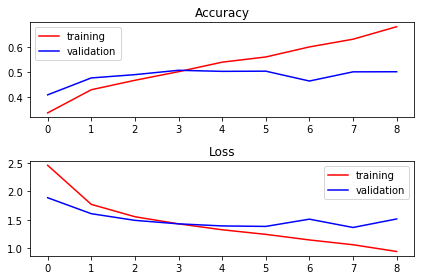

In [11]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="training")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="training")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()